In [12]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random

from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
from Combined_Agent_Double.utils.random_agent import RandomAgent
from Combined_Agent_Double.utils.actions import MORE_ACTIONS
import Combined_Agent_Double.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload

In [13]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [14]:
reload(h_env)
env_name = "random_training_5_mypc"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Dueling_DDQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5)
agent.Q.load(env_name, "episode_1000")

#opponent = RandomAgent(seed)
opponent = h_env.BasicOpponent()

stats, losses = sf.load_stats(env_name)

/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from random_training_5_mypc/weights/episode_1000.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/src/hockey-env/Combined_Agent_Double/QFunction.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(t

Plot saved at random_training_5_mypc/stats/plots/returns_plot.png


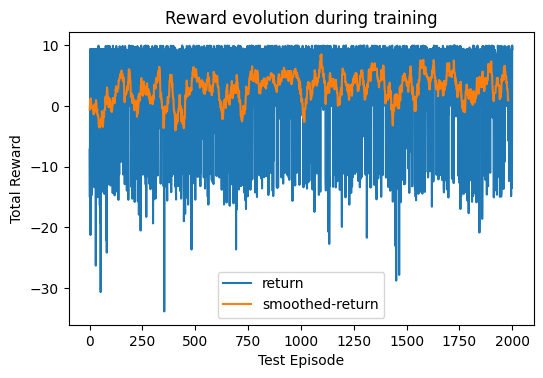

In [15]:
sf.plot_returns(stats, env_name)

Plot saved at random_training_5_mypc/stats/plots/losses_plot.png


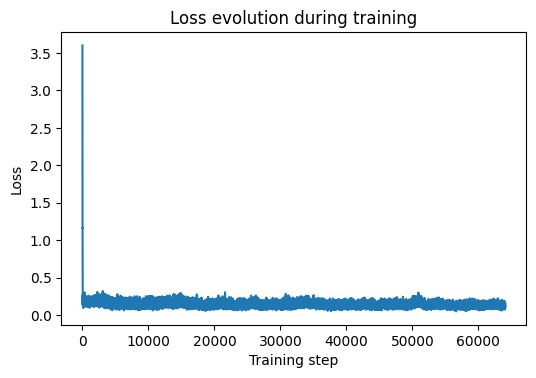

In [16]:
sf.plot_losses(losses, env_name)

Plot saved at random_training_5_mypc/stats/plots/beta_evolution.png


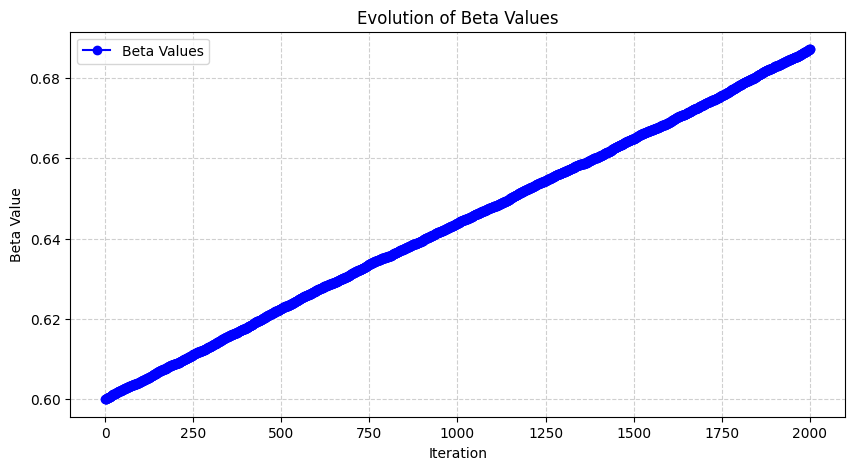

In [17]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at random_training_5_mypc/stats/plots/epsilon_evolution.png


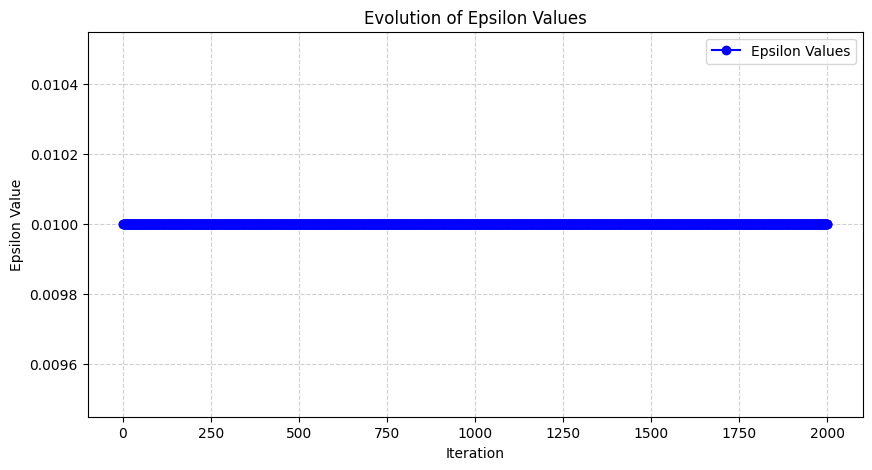

In [18]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at random_training_5_mypc/stats/plots/match_evolution.png


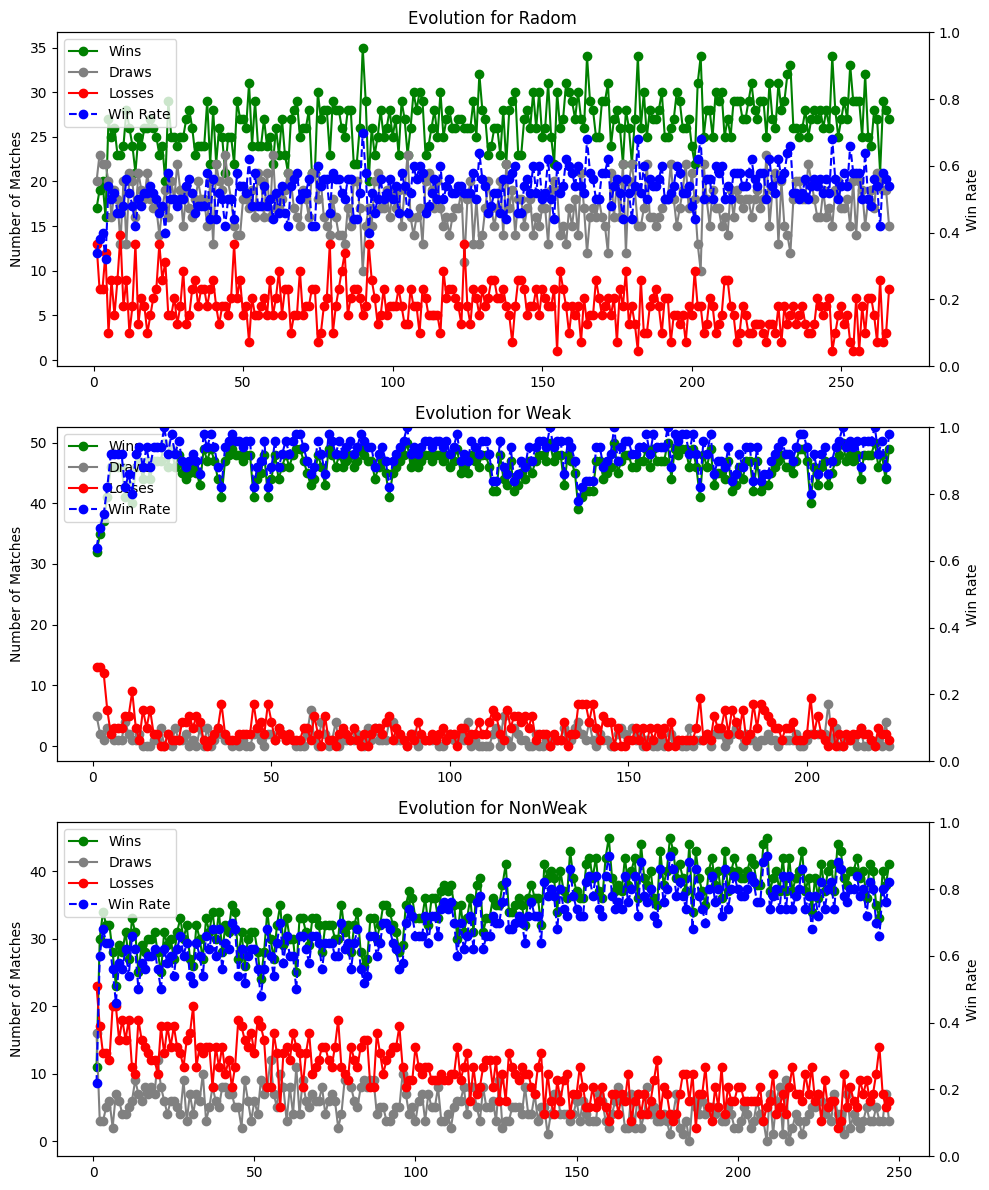

In [20]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history, ["Radom", "Weak", "NonWeak"], 50)

Test Episode 1, Total Reward: 0.0
Test Episode 2, Total Reward: 7.4203043167963205
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: 8.440295315222276
Test Episode 5, Total Reward: 0.0
Test Episode 6, Total Reward: -7.273792983037545
Test Episode 7, Total Reward: 0.0
Test Episode 8, Total Reward: 9.107999177614223
Test Episode 9, Total Reward: -11.227945629170172
Test Episode 10, Total Reward: 9.494185965149104
Plot saved at random_training_5_mypc/stats/plots/test_results.png


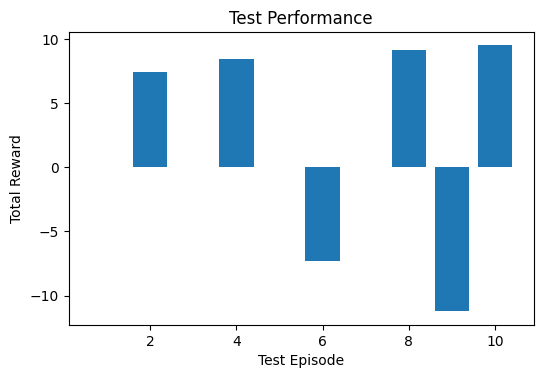

In [21]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = RandomAgent(seed)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}_random.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)

Test Episode 1, Total Reward: 9.391567107360867
Test Episode 2, Total Reward: 8.24597452914874
Test Episode 3, Total Reward: -11.5118081307647
Test Episode 4, Total Reward: 7.117735433549166
Test Episode 5, Total Reward: -15.641658224867669
Test Episode 6, Total Reward: 5.896783971940046
Test Episode 7, Total Reward: 7.939113632483019
Test Episode 8, Total Reward: 7.058792684384482
Test Episode 9, Total Reward: -10.998258387082151
Test Episode 10, Total Reward: 5.321553446094226
Plot saved at random_training_5_mypc/stats/plots/test_results.png


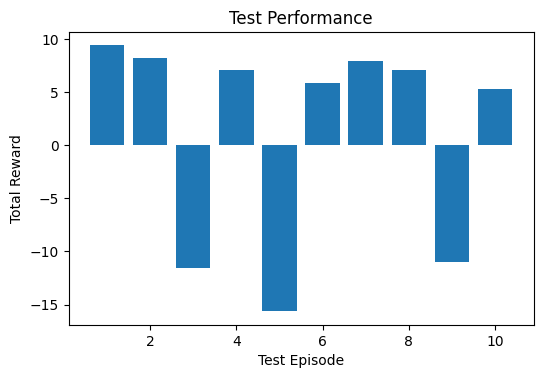

In [24]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent()

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}_weak.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)

Test Episode 1, Total Reward: -17.488631400211368
Test Episode 2, Total Reward: 7.662996013883303
Test Episode 3, Total Reward: 9.521042028096637
Test Episode 4, Total Reward: 4.388493219941096
Test Episode 5, Total Reward: -13.833982831602269
Test Episode 6, Total Reward: 8.298207762966772
Test Episode 7, Total Reward: -1.846374863188699
Test Episode 8, Total Reward: 9.22205746939505
Test Episode 9, Total Reward: 8.255163631437066
Test Episode 10, Total Reward: 9.519594306222325
Plot saved at random_training_5_mypc/stats/plots/test_results.png


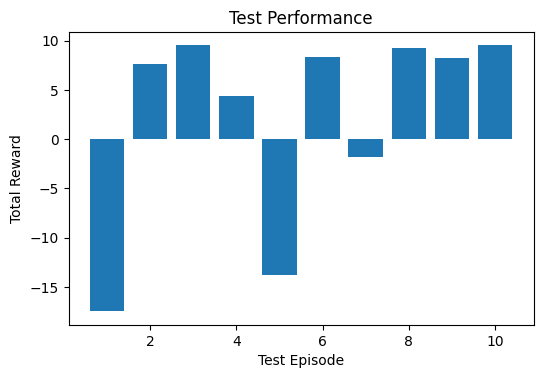

In [25]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent(weak=False)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}_nonweak.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)